# Multimodal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name:

Student number:

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> <b>1.1</b> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>
<br>  
<p> <b>1.2</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>
<br>
<p> <b>1.3</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
<br> 
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [4]:
import numpy as np
import pandas as pd
from os import listdir,getcwd
import math
    
#Reads data from the folders

def read_data_from_folders(folder_name, ID, outputform):
    output = np.empty(outputform, dtype=object)
    
    for n in range(len(ID)):
        #check files in folder.
        currentDir = getcwd()
        filepath = "%s/%s/%02d" %(currentDir, "MEx/" + folder_name, ID[n])
        files = sorted(listdir(filepath))
        count = 0
        
        for f in files:
            file = filepath + "/" + f
            data = pd.read_csv(file, delimiter=',', header=None)
            output[n,count] = data 
            count += 1
            
    return output

folders = ['act', 'dc_0.05_0.05']

allData = np.empty((2,10,8),dtype=object)
num = 0
ids = np.arange(1,11)

for idx,fol in enumerate(folders):
    allData[idx,:,:]=read_data_from_folders(fol, ids, (10,8))
print('Shape of input data: ', allData.shape)

Shape of input data:  (2, 10, 8)


In [6]:
def window_split_file(data,miliseconds=5000):
    step_size=int(data.iloc[1,0]-data.iloc[0,0])
    nr_points=int(miliseconds/step_size)
    new_data=[]

    stop_time=int(data.iloc[-1,0]-miliseconds)#get last one
    out=np.empty((int(stop_time/2000)+1,int(miliseconds/step_size),data.shape[1]-1))
    count=0
    
    for start_time in range(0,stop_time,2000):
        start_index=int(start_time/step_size)
        stop_index=start_index+nr_points
        out[count]=data.iloc[start_index:stop_index,1:]
        count+=1
    return out,step_size

def apply_windowing(data,outputform):
    outData=np.empty((2,10,8),dtype=object)
    count=0
    for sensor in data:
        output = np.empty(outputform, dtype=object)
      
        for p_count,person in enumerate(sensor):
            for f_count,file in enumerate(person):
                step_size=0
                output[p_count,f_count],step_size=window_split_file(sensor[p_count,f_count])
                # if((p_count)*person.shape[0]+f_count==14):
                    # print(p_count,f_count,person.shape[0])
        outData[count]=output
        count+=1
    return outData

def fix_number_windows(data):
    for p_count,person in enumerate(data[0]):
        for e_count,ex in enumerate(person):
            if(ex.shape[0] != data[1,p_count,e_count].shape[0]):
                min_size=min(ex.shape[0] ,data[1,p_count,e_count].shape[0])
                data[0,p_count,e_count]= data[0,p_count,e_count][:min_size];
                data[1,p_count,e_count]= data[1,p_count,e_count][:min_size];
    return data

windowed_data=apply_windowing(allData,(10,8))
windowed_data=fix_number_windows(windowed_data)

1.2 Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence.

Text(0.5, 1.0, 'Person5')

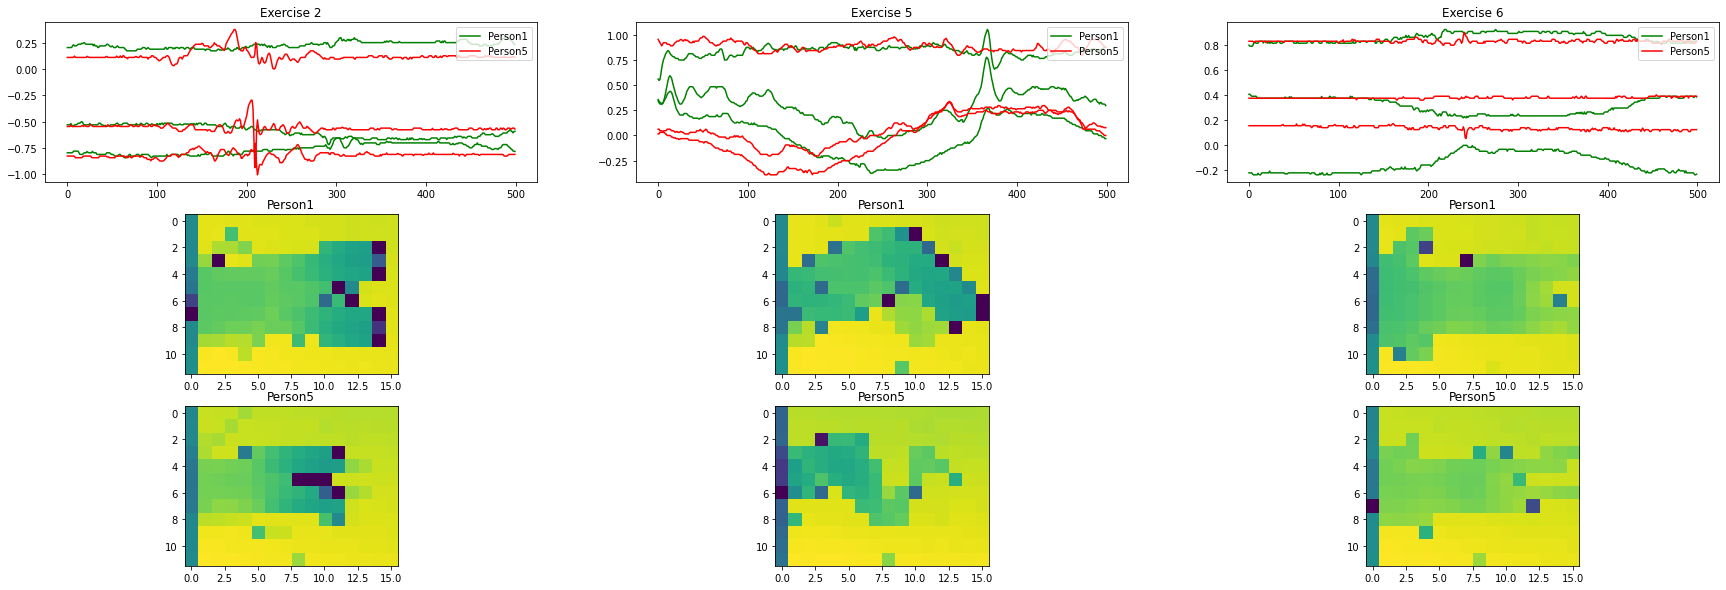

In [20]:
#############    windowed_data[0]                              [0,1]                       [0]   
##############        0 for acc,1 for camera        person 1, exercise 2                  first frame of the exercise
import matplotlib.pyplot as plt
t=range(0,500)
f = plt.figure(figsize=(30,10))
f.add_subplot(3, 3, 1)
plt.title('Exercise 2')
lines_p1 = plt.plot(t,windowed_data[0][0,1][0], 'g')
lines_p2 = plt.plot(t,windowed_data[0][4,1][0], 'r')
plt.legend((lines_p1[0], lines_p2[0]), ('Person1', 'Person5'), loc=1)

f.add_subplot(3, 3, 2)
plt.title('Exercise 5')
lines_p1 = plt.plot(t,windowed_data[0][0,4][0], 'g')
lines_p2 = plt.plot(t,windowed_data[0][4,4][0], 'r')
plt.legend((lines_p1[0], lines_p2[0]), ('Person1', 'Person5'), loc=1)

f.add_subplot(3, 3, 3)
plt.title('Exercise 6')
lines_p1 = plt.plot(t,windowed_data[0][0,5][0], 'g')
lines_p2 = plt.plot(t,windowed_data[0][4,5][0], 'r')
plt.legend((lines_p1[0], lines_p2[0]), ('Person1', 'Person5'), loc=1)

f.add_subplot(3, 3, 4)
image=windowed_data[1][0,1][0,0].reshape((12,16))
plt.title('Person1')
plt.imshow(image)

f.add_subplot(3, 3, 7)
image=windowed_data[1][4,1][0,0].reshape((12,16))
plt.title('Person5')
plt.imshow(image)

f.add_subplot(3, 3, 5)
image=windowed_data[1][0,4][0,0].reshape((12,16))
plt.imshow(image)
plt.title('Person1')

f.add_subplot(3, 3, 8)
image=windowed_data[1][4,4][0,0].reshape((12,16))
plt.imshow(image)
plt.title('Person5')

f.add_subplot(3, 3, 6)
image=windowed_data[1][0,5][0,0].reshape((12,16))
plt.imshow(image)
plt.title('Person1')

f.add_subplot(3, 3, 9)
image=windowed_data[1][4,5][0,0].reshape((12,16))
plt.imshow(image)
plt.title('Person5')

1.3 Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.


In [22]:
def create_data_set(data):
    out_data=np.empty((0,data[0,0].shape[1],data[0,0].shape[2]))
    out_labels=np.empty(0,dtype=int)
    for idx,person in enumerate(data):
        for idy,exercise in enumerate(person):
            out_data=np.concatenate((out_data,exercise))
            labels=np.full(exercise.shape[0],idy)### create labels array with the id of the exercise - 1
            out_labels=np.concatenate((out_labels,labels))
    print("Out shape:",out_data.shape," Label shape:",out_labels.shape)
    return out_data, out_labels

training_data_slice=windowed_data[:,:7,:]
testing_data_slice=windowed_data[:,7:,:]
x_train_acc,y_train_acc=create_data_set(training_data_slice[0])
x_test_acc,y_test_acc=create_data_set(testing_data_slice[0])
x_train_cam,y_train_cam=create_data_set(training_data_slice[1])
x_test_cam,y_test_cam=create_data_set(testing_data_slice[1])

Out shape: (1486, 500, 3)  Label shape: (1486,)
Out shape: (598, 500, 3)  Label shape: (598,)
Out shape: (1486, 5, 192)  Label shape: (1486,)
Out shape: (598, 5, 192)  Label shape: (598,)


# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages-19-20) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 2.1-2.2.
    
</div>

In [5]:

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import signal
def downsample(data):
    
    m=signal.resample(data,125)
   
    return m
def standardise(data):
    mean=np.mean(data,axis=0)
    std=np.std(data,axis=0)
    print(mean.shape)
    print(std.shape)
    res=(data-mean)/std
    print("After standar",res.shape)
    
    return res
def preprocess(data,resample=True):
    aux=standardise(data)
    if(resample):
        aux=np.apply_along_axis(downsample, 1, aux)
    return aux

In [6]:


x_train_acc_p=preprocess (x_train_acc)
x_test_acc_p=preprocess (x_test_acc)


pca_acc_1 = PCA(n_components=5)
pca_acc_2 = PCA(n_components=5)
pca_acc_3 = PCA(n_components=5)

lda_acc_1=LinearDiscriminantAnalysis(n_components=5)
lda_acc_2=LinearDiscriminantAnalysis(n_components=5)
lda_acc_3=LinearDiscriminantAnalysis(n_components=5)

x_acc_1_train_pca=pca_acc_1.fit_transform(x_train_acc_p[:,:,0])
x_acc_2_train_pca=pca_acc_2.fit_transform(x_train_acc_p[:,:,1])
x_acc_3_train_pca=pca_acc_3.fit_transform(x_train_acc_p[:,:,2])

x_acc_1_test_pca=pca_acc_1.transform(x_test_acc_p[:,:,0])
x_acc_2_test_pca=pca_acc_2.transform(x_test_acc_p[:,:,1])
x_acc_3_test_pca=pca_acc_3.transform(x_test_acc_p[:,:,2])

x_acc_1_train_lda=lda_acc_1.fit_transform(x_train_acc_p[:,:,0],y_train_acc)
x_acc_2_train_lda=lda_acc_2.fit_transform(x_train_acc_p[:,:,1],y_train_acc)
x_acc_3_train_lda=lda_acc_3.fit_transform(x_train_acc_p[:,:,2],y_train_acc)

x_acc_1_test_lda=lda_acc_1.transform(x_test_acc_p[:,:,0])
x_acc_2_test_lda=lda_acc_2.transform(x_test_acc_p[:,:,1])
x_acc_3_test_lda=lda_acc_3.transform(x_test_acc_p[:,:,2])

pca_train_acc=np.concatenate((x_acc_1_train_pca,x_acc_2_train_pca,x_acc_3_train_pca),axis=1)
lda_train_acc=np.concatenate((x_acc_1_train_lda,x_acc_2_train_lda,x_acc_3_train_lda),axis=1)

pca_test_acc=np.concatenate((x_acc_1_test_pca,x_acc_2_test_pca,x_acc_3_test_pca),axis=1)
lda_test_acc=np.concatenate((x_acc_1_test_lda,x_acc_2_test_lda,x_acc_3_test_lda),axis=1)



# pca_test_acc=np.concatenate((x_acc_1_test,x_acc_2_test,x_acc_3_test),axis=1)


# x_test_pca_acc=pca_acc.transform(x_test_acc.reshape(-1,3))

print(pca_train_acc.shape)
print(lda_train_acc.shape)

print(pca_test_acc.shape)
print(lda_test_acc.shape)
pca_lda_train_acc=np.concatenate((pca_train_acc,lda_train_acc),axis=1)
pca_lda_test_acc=np.concatenate((pca_test_acc,lda_test_acc),axis=1)
print(pca_lda_train_acc.shape)
print(pca_lda_test_acc.shape)
# print(x_train_acc[0,0])


(500, 3)
(500, 3)
After standar (1486, 500, 3)
(500, 3)
(500, 3)
After standar (598, 500, 3)
(1486, 15)
(1486, 15)
(598, 15)
(598, 15)
(1486, 30)
(598, 30)


2.1 Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages-19-20) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results.

In [7]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
def PCA_LDA_fusion(train,test,y_train):
    predicted_labels=[]
    for row in test:
#         print(row.shape)
#         print(train[:,0:3].shape)
        d=train[:,0:15]-row[0:15]
        D=train[:,15:30]-row[15:30]
#         print("Dasda",train[:,15:30].shape,train[:,15:].shape)
#         print(d.shape)
        d=np.sum(d**2,axis=1)
        D=np.sum(D**2,axis=1)
        d=(d-np.amin(d))/(np.amax(d)-np.amin(d))
        D=(D-np.amin(D))/(np.amax(D)-np.amin(D))
        F=(d+D)/2
#         print(F)
        label_index=np.argmin(F)
        predicted_label=int(y_train[label_index])
        predicted_labels.append(predicted_label)
    return predicted_labels
        


In [8]:
        
predicted=PCA_LDA_fusion(pca_lda_train_acc,pca_lda_test_acc,y_train_acc)
# print(predicted)
# print(y_test_acc)
print("ACC:",accuracy_score(y_test_acc,predicted))
print("F1 score:",f1_score(y_test_acc,predicted,average=None))
confusion_matrix(y_test_acc,predicted)
# print(predicted)

ACC: 0.44648829431438125
F1 score: [0.31067961 0.29824561 0.30939227 0.81818182 0.40909091 0.46715328
 0.51737452 0.53731343]


array([[16,  7, 34,  0,  0,  1, 27,  0],
       [ 2, 34, 11,  0,  0,  7, 26,  4],
       [ 0, 29, 28,  0,  0,  0, 24,  5],
       [ 0,  0,  0, 45,  2,  0,  0,  0],
       [ 0,  0,  0, 18,  9,  6,  0,  0],
       [ 0, 44, 13,  0,  0, 32,  0,  1],
       [ 0, 15,  3,  0,  0,  0, 67,  3],
       [ 0, 15,  6,  0,  0,  1, 27, 36]], dtype=int64)

In [9]:

print(x_train_cam.shape)

x_train_cam_p=preprocess(x_train_cam,resample=False)
x_test_cam_p=preprocess(x_test_cam,resample=False)
print("After processing",x_train_cam_p.shape)
pca_cam_1 = PCA(n_components=5)
pca_cam_2 = PCA(n_components=5)
pca_cam_3 = PCA(n_components=5)
pca_cam_4 = PCA(n_components=5)
pca_cam_5 = PCA(n_components=5)


lda_cam_1=LinearDiscriminantAnalysis(n_components=5)
lda_cam_2=LinearDiscriminantAnalysis(n_components=5)
lda_cam_3=LinearDiscriminantAnalysis(n_components=5)
lda_cam_4=LinearDiscriminantAnalysis(n_components=5)
lda_cam_5=LinearDiscriminantAnalysis(n_components=5)

x_cam_1_train_pca=pca_cam_1.fit_transform(x_train_cam_p[:,0,:])
x_cam_2_train_pca=pca_cam_2.fit_transform(x_train_cam_p[:,1,:])
x_cam_3_train_pca=pca_cam_3.fit_transform(x_train_cam_p[:,2,:])
x_cam_4_train_pca=pca_cam_4.fit_transform(x_train_cam_p[:,3,:])
x_cam_5_train_pca=pca_cam_5.fit_transform(x_train_cam_p[:,4,:])


x_cam_1_test_pca=pca_cam_1.transform(x_test_cam_p[:,0,:])
x_cam_2_test_pca=pca_cam_2.transform(x_test_cam_p[:,1,:])
x_cam_3_test_pca=pca_cam_3.transform(x_test_cam_p[:,2,:])
x_cam_4_test_pca=pca_cam_4.transform(x_test_cam_p[:,3,:])
x_cam_5_test_pca=pca_cam_5.transform(x_test_cam_p[:,4,:])

x_cam_1_train_lda=lda_cam_1.fit_transform(x_train_cam_p[:,0,:],y_train_cam)
x_cam_2_train_lda=lda_cam_2.fit_transform(x_train_cam_p[:,1,:],y_train_cam)
x_cam_3_train_lda=lda_cam_3.fit_transform(x_train_cam_p[:,2,:],y_train_cam)
x_cam_4_train_lda=lda_cam_4.fit_transform(x_train_cam_p[:,3,:],y_train_cam)
x_cam_5_train_lda=lda_cam_5.fit_transform(x_train_cam_p[:,4,:],y_train_cam)

x_cam_1_test_lda=lda_cam_1.transform(x_test_cam_p[:,0,:])
x_cam_2_test_lda=lda_cam_2.transform(x_test_cam_p[:,1,:])
x_cam_3_test_lda=lda_cam_3.transform(x_test_cam_p[:,2,:])
x_cam_4_test_lda=lda_cam_4.transform(x_test_cam_p[:,3,:])
x_cam_5_test_lda=lda_cam_5.transform(x_test_cam_p[:,4,:])

pca_train_cam=np.concatenate((x_cam_1_train_pca,x_cam_2_train_pca,x_cam_3_train_pca,x_cam_4_train_pca,x_cam_5_train_pca),axis=1)
lda_train_cam=np.concatenate((x_cam_1_train_lda,x_cam_2_train_lda,x_cam_3_train_lda,x_cam_4_train_lda,x_cam_5_train_lda),axis=1)

pca_test_cam=np.concatenate((x_cam_1_test_pca,x_cam_2_test_pca,x_cam_3_test_pca,x_cam_4_test_pca,x_cam_5_test_pca),axis=1)
lda_test_cam=np.concatenate((x_cam_1_test_lda,x_cam_2_test_lda,x_cam_3_test_lda,x_cam_4_test_lda,x_cam_5_test_lda),axis=1)

print(pca_train_cam.shape)
print(lda_train_cam.shape)

print(pca_test_cam.shape)
print(lda_test_cam.shape)
pca_lda_train_cam=np.concatenate((pca_train_cam,lda_train_cam),axis=1)
pca_lda_test_cam=np.concatenate((pca_test_cam,pca_test_cam),axis=1)
print(pca_lda_train_cam)
print(pca_lda_test_cam.shape)


(1486, 5, 192)
(5, 192)
(5, 192)
After standar (1486, 5, 192)
(5, 192)
(5, 192)
After standar (598, 5, 192)
After processing (1486, 5, 192)
(1486, 25)
(1486, 25)
(598, 25)
(598, 25)
[[-3.33369095  1.25878074  2.64742178 ... -3.85231192  2.6240902
  -1.62688376]
 [-2.74286065  2.7982717  -1.84449137 ... -2.22968309  0.83410659
  -0.72416775]
 [-2.34070718  2.84802886  0.5024801  ... -3.5223537   2.05621398
  -2.12087323]
 ...
 [ 7.61241439 -5.46706476 -0.09681634 ... -0.53231533  1.96970874
  -0.67511362]
 [ 9.03406911 -5.689773   -0.91177089 ...  0.30374386  1.83254539
  -0.96454372]
 [ 8.97726327 -5.31921839 -1.81708026 ... -0.13217389  1.40475224
   0.11161582]]
(598, 50)


In [10]:
predicted=PCA_LDA_fusion(pca_lda_train_cam,pca_lda_test_cam,y_train_cam)
print("ACC:",accuracy_score(y_test_cam,predicted))
print("F1 score:",f1_score(y_test_cam,predicted,average=None))
confusion_matrix(y_test_cam,predicted)
print(predicted)

ACC: 0.6153846153846154
F1 score: [0.79591837 0.59893048 0.67080745 0.10169492 0.19847328 0.76190476
 0.73513514 0.61538462]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 1, 4, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 6, 6, 6, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 6, 4, 4, 4, 6, 6, 4, 4, 4, 3, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   
<br> 
<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>
<br>  
<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>
<br> 
<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.
    
</div>

In [11]:

x_train_acc_p=preprocess (x_train_acc)
x_test_acc_p=preprocess (x_test_acc)
x_train_cam_p=preprocess(x_train_cam,resample=False)
x_test_cam_p=preprocess(x_test_cam,resample=False)

pca_acc_1 = PCA(n_components=10)
pca_acc_2 = PCA(n_components=10)
pca_acc_3 = PCA(n_components=10)

x_acc_1_train_pca=pca_acc_1.fit_transform(x_train_acc_p[:,:,0])
x_acc_2_train_pca=pca_acc_2.fit_transform(x_train_acc_p[:,:,1])
x_acc_3_train_pca=pca_acc_3.fit_transform(x_train_acc_p[:,:,2])

x_acc_1_test_pca=pca_acc_1.transform(x_test_acc_p[:,:,0])
x_acc_2_test_pca=pca_acc_2.transform(x_test_acc_p[:,:,1])
x_acc_3_test_pca=pca_acc_3.transform(x_test_acc_p[:,:,2])

pca_train_mean=np.mean(x_train_acc_p,axis=1)
pca_train_std=np.std(x_train_acc_p,axis=1)
pca_test_mean=np.mean(x_test_acc_p,axis=1)
pca_test_std=np.std(x_test_acc_p,axis=1)
print("pca_mean:",pca_train_mean.shape)
print("pca_std:",pca_test_mean.shape)

pca_train_acc=np.concatenate((x_acc_1_train_pca,x_acc_2_train_pca,x_acc_3_train_pca,pca_train_mean,pca_train_std),axis=1)
pca_test_acc=np.concatenate((x_acc_1_test_pca,x_acc_2_test_pca,x_acc_3_test_pca,pca_test_mean,pca_test_std),axis=1)


pca_cam_1 = PCA(n_components=10)
pca_cam_2 = PCA(n_components=10)
pca_cam_3 = PCA(n_components=10)
pca_cam_4 = PCA(n_components=10)
pca_cam_5 = PCA(n_components=10)

x_cam_1_train_pca=pca_cam_1.fit_transform(x_train_cam_p[:,0,:])
x_cam_2_train_pca=pca_cam_2.fit_transform(x_train_cam_p[:,1,:])
x_cam_3_train_pca=pca_cam_3.fit_transform(x_train_cam_p[:,2,:])
x_cam_4_train_pca=pca_cam_4.fit_transform(x_train_cam_p[:,3,:])
x_cam_5_train_pca=pca_cam_5.fit_transform(x_train_cam_p[:,4,:])


x_cam_1_test_pca=pca_cam_1.transform(x_test_cam_p[:,0,:])
x_cam_2_test_pca=pca_cam_2.transform(x_test_cam_p[:,1,:])
x_cam_3_test_pca=pca_cam_3.transform(x_test_cam_p[:,2,:])
x_cam_4_test_pca=pca_cam_4.transform(x_test_cam_p[:,3,:])
x_cam_5_test_pca=pca_cam_5.transform(x_test_cam_p[:,4,:])



pca_train_cam=np.concatenate((x_cam_1_train_pca,x_cam_2_train_pca,x_cam_3_train_pca,x_cam_4_train_pca,x_cam_5_train_pca),axis=1)
pca_test_cam=np.concatenate((x_cam_1_test_pca,x_cam_2_test_pca,x_cam_3_test_pca,x_cam_4_test_pca,x_cam_5_test_pca),axis=1)


# pca_test_acc=np.concatenate((x_acc_1_test,x_acc_2_test,x_acc_3_test),axis=1)


# x_test_pca_acc=pca_acc.transform(x_test_acc.reshape(-1,3))

print("pca_train_acc:",pca_train_acc.shape)

print("pca_test_acc:",pca_test_acc.shape)
print("pca_train_cam:",pca_train_cam.shape)

pca_acc_cam_train=np.concatenate((pca_train_acc,pca_train_cam),axis=1)
pca_acc_cam_test=np.concatenate((pca_test_acc,pca_test_cam),axis=1)
print("pca_acc_cam_train:",pca_acc_cam_train.shape)
print("pca_acc_cam_test:",pca_acc_cam_test.shape)
                           
train_max=np.max(pca_acc_cam_train,axis=0)
train_min=np.min(pca_acc_cam_train,axis=0)
print("Max shape",train_max.shape)
pca_acc_cam_train=(pca_acc_cam_train-train_min)/(train_max-train_min)
pca_acc_cam_test=(pca_acc_cam_test-train_min)/(train_max-train_min)


(500, 3)
(500, 3)
After standar (1486, 500, 3)
(500, 3)
(500, 3)
After standar (598, 500, 3)
(5, 192)
(5, 192)
After standar (1486, 5, 192)
(5, 192)
(5, 192)
After standar (598, 5, 192)
pca_mean: (1486, 3)
pca_std: (598, 3)
pca_train_acc: (1486, 36)
pca_test_acc: (598, 36)
pca_train_cam: (1486, 50)
pca_acc_cam_train: (1486, 86)
pca_acc_cam_test: (598, 86)
Max shape (86,)


3.3 Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.



SVM acc: 0.7876254180602007
Bayes acc: 0.7792642140468228
SVM F1: 0.7348381477322501
BAYES F1: 0.7491404881029358


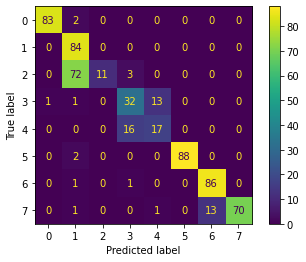

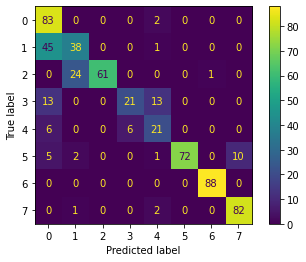

In [12]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
svm=SVC(kernel='rbf')
bayes=GaussianNB()
svm.fit(pca_acc_cam_train,y_train_acc)
bayes.fit(pca_acc_cam_train,y_train_acc)
print("SVM acc:",svm.score(pca_acc_cam_test,y_test_acc))
print("Bayes acc:",bayes.score(pca_acc_cam_test,y_test_acc))
plot_confusion_matrix(svm, pca_acc_cam_test, y_test_acc)  
plot_confusion_matrix(bayes, pca_acc_cam_test, y_test_acc)
pred_svm=svm.predict(pca_acc_cam_test)
pred_bayes=bayes.predict(pca_acc_cam_test)
print("SVM F1:",f1_score(pred_svm, y_test_acc, average='macro'))
print("BAYES F1:",f1_score(pred_bayes, y_test_acc, average='macro'))


# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$. Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>
<br>
<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes in each subtasks 4.1-4.3.
    
</div>

Normalize data

In [13]:
train_max = np.max(pca_train_acc, axis=0)
train_min = np.min(pca_train_acc, axis=0)

pca_train_acc_n = (pca_train_acc - train_min) / (train_max - train_min)
pca_test_acc_n = (pca_test_acc - train_min) / (train_max - train_min)

train_max = np.max(pca_train_cam, axis=0)
train_min = np.min(pca_train_cam, axis=0)

pca_train_cam_n = (pca_train_cam - train_min) / (train_max - train_min)
pca_test_cam_n = (pca_test_cam - train_min) / (train_max - train_min)

Base classifiers for accelerometer

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

#####################
####Accelerometer####
#####################
svm = SVC(kernel='rbf')
parameters_svm = {'C' : [0.1,1.0,10.0,100.0], 'gamma' : [0.1,0.25,0.5,0.75,1.0,2.0]}
clf_svm = GridSearchCV(svm, parameters_svm, cv=10, n_jobs=-1)
clf_svm.fit(pca_train_acc_n, y_train_acc)
print('SVM: ', clf_svm.best_score_)

adaboost = AdaBoostClassifier(random_state=0)
parameters_ada = {'n_estimators' : [50,100,500,1000], 'learning_rate': [0.1,0.25,0.5,0.75,1.0]}
clf_ada = GridSearchCV(adaboost, parameters_ada, cv=10, n_jobs=-1)
clf_ada.fit(pca_train_acc_n, y_train_acc)
print('Adaboost: ', clf_ada.best_score_)

print('------------------------')

#####################
####Camera###########
#####################
svm_cam = SVC(kernel='rbf')
clf_svm_cam = GridSearchCV(svm_cam, parameters_svm, cv=10, n_jobs=-1)
clf_svm_cam.fit(pca_train_cam_n, y_train_cam)
print('SVM: ', clf_svm_cam.best_score_)

adaboost_cam = AdaBoostClassifier(random_state=0)
clf_ada_cam = GridSearchCV(adaboost_cam, parameters_ada, cv=10, n_jobs=-1)
clf_ada_cam.fit(pca_train_cam_n, y_train_cam)
print('Adaboost: ', clf_ada_cam.best_score_)

SVM:  0.9737529475784509
Adaboost:  0.8177172138581534
------------------------
SVM:  0.9562715399963722
Adaboost:  0.5523762017050609


We have obtained the best configuration for accelerometer and camera modalities, for both SVM and Adaboost. For both modalities, the best score is obtained by the SVM.

Best parameters.

In [15]:
print('Accelerometer')
print(clf_svm.cv_results_['params'][clf_svm.best_index_])
print(clf_ada.cv_results_['params'][clf_ada.best_index_])

print('--------------')

print('Camera')
print(clf_svm_cam.cv_results_['params'][clf_svm_cam.best_index_])
print(clf_ada_cam.cv_results_['params'][clf_ada_cam.best_index_])

Accelerometer
{'C': 100.0, 'gamma': 0.75}
{'learning_rate': 0.5, 'n_estimators': 1000}
--------------
Camera
{'C': 10.0, 'gamma': 0.75}
{'learning_rate': 0.5, 'n_estimators': 50}


Train using the best parameters.

In [16]:
svm_best_acc = SVC(kernel='rbf', C=100, gamma=0.75, probability=True)
svm_best_acc.fit(pca_train_acc_n, y_train_acc)

ada_best_acc = AdaBoostClassifier(learning_rate=0.5, n_estimators=1000, random_state=0)
ada_best_acc.fit(pca_train_acc_n, y_train_acc)

svm_best_cam = SVC(kernel='rbf', C=10, gamma=0.75, probability=True)
svm_best_cam.fit(pca_train_cam_n, y_train_cam)

ada_best_cam = AdaBoostClassifier(learning_rate=0.25, n_estimators=100, random_state=0)
ada_best_cam.fit(pca_train_cam_n, y_train_cam)

AdaBoostClassifier(learning_rate=0.25, n_estimators=100, random_state=0)

Predict probabilities on the test set.

In [17]:
print('Accelerometer')
print('Test SVM score: ', svm_best_acc.score(pca_test_acc_n, y_test_acc))
yprob_svm_acc = svm_best_acc.predict_proba(pca_test_acc_n)
ypred_svm_acc = svm_best_acc.predict(pca_test_acc_n)
y_belief_svm_acc = svm_best_acc.decision_function(pca_test_acc_n)

print('Test AdaBoost score: ', ada_best_acc.score(pca_test_acc_n, y_test_acc))
yprob_ada_acc = ada_best_acc.predict_proba(pca_test_acc_n)
ypred_ada_acc = ada_best_acc.predict(pca_test_acc_n)
y_belief_ada_acc = ada_best_acc.decision_function(pca_test_acc_n)

print('---------------')

print('Camera')
print('Test SVM score: ', svm_best_cam.score(pca_test_cam_n, y_test_cam))
yprob_svm_cam = svm_best_cam.predict_proba(pca_test_cam_n)
ypred_svm_cam = svm_best_cam.predict(pca_test_cam_n)
y_belief_svm_cam = svm_best_cam.decision_function(pca_test_cam_n)

print('Test AdaBoost score: ', ada_best_cam.score(pca_test_cam_n, y_test_cam))
yprob_ada_cam = ada_best_cam.predict_proba(pca_test_cam_n)
ypred_ada_cam = ada_best_cam.predict(pca_test_cam_n)
y_belief_ada_cam = ada_best_cam.decision_function(pca_test_cam_n)

Accelerometer
Test SVM score:  0.5836120401337793
Test AdaBoost score:  0.5484949832775919
---------------
Camera
Test SVM score:  0.7608695652173914
Test AdaBoost score:  0.4983277591973244


Again, the SVMs prove to have the best score, although there is quite a big decrease in accuracy.

# $SVM_{acc} \& SVM_{depth}$

In [27]:
y_test = y_test_cam
y_train = y_train_cam

labels = np.zeros((2, np.max(y_train)+1,len(y_test)))
for count in range(len(y_test)):
    labels[0, ypred_svm_acc[count], count] = 1
    labels[1, ypred_svm_cam[count], count] = 1
    
posterior_scores = np.array((yprob_svm_acc, yprob_svm_cam))    

conf_m =  confusion_matrix(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1), average='macro')
print('Prod: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1), average='macro')
print('Sum: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1), average='macro')
print('Max: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1), average='macro')
print('Min: ')
print(conf_m)
print('F1 score: ', F1_score)

Prod: 
[[85  0  0  0  0  0  0  0]
 [ 1 56  0  0  0  0 25  2]
 [ 0 35 22  0  0  0 29  0]
 [ 4  1  0 30 12  0  0  0]
 [ 0  0  0 14 19  0  0  0]
 [ 0  2  0  0  0 87  0  1]
 [ 0  2  0  0  0  0 83  3]
 [ 0  1  0  0  0  0  3 81]]
F1 score:  0.7379615820719851
Sum: 
[[83  0  0  0  0  0  0  2]
 [ 0 55  4  0  0  0 24  1]
 [ 0 34 23  0  0  0 29  0]
 [ 1  1  0 28 17  0  0  0]
 [ 0  0  0 14 19  0  0  0]
 [ 0  8  0  0  0 81  0  1]
 [ 0  4  0  0  0  0 79  5]
 [ 0  1  0  0  0  0  3 81]]
F1 score:  0.7173880584764682
Max: 
[[83  0  0  0  0  0  0  2]
 [ 0 55  5  0  0  0 23  1]
 [ 0 35 22  0  0  0 29  0]
 [ 0  1  0 25 21  0  0  0]
 [ 0  0  0 15 18  0  0  0]
 [ 0 10  0  0  0 79  0  1]
 [ 0  7  0  0  0  0 73  8]
 [ 0  1  0  0  0  0  3 81]]
F1 score:  0.6928857659194232
Min: 
[[84  0  0  0  0  0  0  1]
 [ 2 53  0  0  2  0  0 27]
 [ 0 37 20  0  0  0  4 25]
 [ 9  0  0 26 12  0  0  0]
 [ 0  0  0 12 21  0  0  0]
 [ 0  2  0  0  0 87  0  1]
 [ 0  2  0  0  0  0 86  0]
 [ 0  1  0  0  0  0  3 81]]
F1 score:  0.7252

# $Adaboost_{acc} \& SVM_{depth}$

In [28]:
labels = np.zeros((2, np.max(y_train)+1,len(y_test)))
for count in range(len(y_test)):
    labels[0, ypred_ada_acc[count], count] = 1
    labels[1, ypred_svm_cam[count], count] = 1
    
posterior_scores = np.array((yprob_ada_acc, yprob_svm_cam))    

conf_m =  confusion_matrix(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1), average='macro')
print('Prod: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1), average='macro')
print('Sum: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1), average='macro')
print('Max: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1), average='macro')
print('Min: ')
print(conf_m)
print('F1 score: ', F1_score)

Prod: 
[[83  2  0  0  0  0  0  0]
 [ 1 53  7  0 23  0  0  0]
 [ 0 17 69  0  0  0  0  0]
 [11  1  0 35  0  0  0  0]
 [ 0  1  0 17 14  0  0  1]
 [ 0  2  0  0  0 88  0  0]
 [ 0  2  0  0  0  0 54 32]
 [ 0  0  0  0  0  0  0 85]]
F1 score:  0.7652789522087415
Sum: 
[[83  2  0  0  0  0  0  0]
 [ 1 45 17  0 21  0  0  0]
 [ 1 17 68  0  0  0  0  0]
 [12  1  0 29  5  0  0  0]
 [ 0  2  0  8 23  0  0  0]
 [ 0  2  0  0  0 88  0  0]
 [ 0  2  0  0  0  0 59 27]
 [ 0  1  0  0  0  0  1 83]]
F1 score:  0.7716409775241684
Max: 
[[84  1  0  0  0  0  0  0]
 [ 2 42 21  0  2  0  0 17]
 [ 1 17 68  0  0  0  0  0]
 [12  1  0 23  6  5  0  0]
 [ 0  2  0  7 24  0  0  0]
 [ 0  2  0  0  0 88  0  0]
 [ 0  2  0  0  0  0 63 23]
 [ 0  1  0  0  0  0  2 82]]
F1 score:  0.7695288284075856
Min: 
[[83  0  0  0  0  0  0  2]
 [ 1 58  0  0 24  0  0  1]
 [ 0 26 60  0  0  0  0  0]
 [11  0  0 35  0  0  0  1]
 [ 0  7  2  8 14  0  0  2]
 [ 0  2  0  0  0 87  0  1]
 [ 0  2  0  0  0  0 44 42]
 [ 0  0  0  0  0  0  0 85]]
F1 score:  0.7473

# $SVM_{acc} \& Adaboost_{depth}$

In [29]:
labels = np.zeros((2, np.max(y_train)+1,len(y_test)))
for count in range(len(y_test)):
    labels[0, ypred_svm_acc[count], count] = 1
    labels[1, ypred_ada_cam[count], count] = 1
    
posterior_scores = np.array((yprob_svm_acc, yprob_ada_cam))    

conf_m =  confusion_matrix(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1), average='macro')
print('Prod: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1), average='macro')
print('Mean: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1), average='macro')
print('Sum: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1), average='macro')
print('Min: ')
print(conf_m)
print('F1 score: ', F1_score)

Prod: 
[[85  0  0  0  0  0  0  0]
 [12 43  0  0  0  0 28  1]
 [ 0 34 23  0  0  0 29  0]
 [ 4  0  0 30 13  0  0  0]
 [ 0  0  0 15 18  0  0  0]
 [ 0  9  1  0  0 79  0  1]
 [ 0  6  0  0  0  0 82  0]
 [ 0  1  0  0  0  0  4 80]]
F1 score:  0.7044577146199039
Mean: 
[[75  0  0  0  0  0  0 10]
 [ 8 41  0  0  0  6 28  1]
 [ 0 34 23  0  0  0 29  0]
 [ 4  0  0 30 13  0  0  0]
 [ 0  0  0 15 18  0  0  0]
 [ 0 21  0  0  0 67  0  2]
 [ 0 16  0  0  0  0 64  8]
 [ 0  1  0  0  0  0  4 80]]
F1 score:  0.651033606276953
Sum: 
[[69  0  0  0  0  0  0 16]
 [ 6 41  0  0  0  8 28  1]
 [ 0 34 23  0  0  0 29  0]
 [ 4  0  0 30 13  0  0  0]
 [ 0  0  0 15 18  0  0  0]
 [ 0 27  0  0  0 59  0  4]
 [ 0 20  0  0  0  0 51 17]
 [ 0  4  0  0  0  0  4 77]]
F1 score:  0.6125280279331957
Min: 
[[85  0  0  0  0  0  0  0]
 [14 42  0  0  0  0 10 18]
 [ 0 28 29  0  0  0  8 21]
 [ 6  0  0 28 13  0  0  0]
 [ 0  0  0 10 23  0  0  0]
 [ 4  2  1  0  0 82  0  1]
 [ 0  3  0  0  0  0 85  0]
 [ 0  0  0  0  4  0  2 79]]
F1 score:  0.7252

# $Adaboost_{acc} \& Adaboost_{depth}$

In [30]:
labels = np.zeros((2, np.max(y_train)+1,len(y_test)))
for count in range(len(y_test)):
    labels[0, ypred_ada_acc[count], count] = 1
    labels[1, ypred_ada_cam[count], count] = 1
    
posterior_scores = np.array((yprob_ada_acc, yprob_ada_cam))    

conf_m =  confusion_matrix(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1), average='macro')
print('Prod: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1), average='macro')
print('Sum: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1), average='macro')
print('Max: ')
print(conf_m)
print('F1 score: ', F1_score)

conf_m = confusion_matrix(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1))
F1_score = f1_score(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1), average='macro')
print('Min: ')
print(conf_m)
print('F1 score: ', F1_score)

Prod: 
[[85  0  0  0  0  0  0  0]
 [22 38  0  0 24  0  0  0]
 [ 0 27 59  0  0  0  0  0]
 [13  0  0 19 13  2  0  0]
 [ 2  0  0 18 13  0  0  0]
 [ 2  1  1  0  0 86  0  0]
 [ 0  1  0  0  0 18  0 69]
 [ 2  0  0  0  4  3  0 76]]
F1 score:  0.5492050425628744
Sum: 
[[85  0  0  0  0  0  0  0]
 [22 37  0  0 24  0  0  1]
 [ 0 27 58  0  0  0  0  1]
 [13  0  0  3 11 18  0  2]
 [ 1  0  0 18 14  0  0  0]
 [ 1  0  1  0  0 88  0  0]
 [ 0  1  0  0  0 17  0 70]
 [ 0  0  0  0  3  2  0 80]]
F1 score:  0.5029510138601604
Max: 
[[84  0  0  0  0  0  0  1]
 [22 26  5  0  1  0  0 30]
 [ 0  0 62  0  0  0  0 24]
 [13  0  0  0 10 21  0  3]
 [ 0  0  0 18  7  0  0  8]
 [ 1  0  0  0  0 85  0  4]
 [ 0  1  0  0  0 10  0 77]
 [ 0  0  0  0  0  3  0 82]]
F1 score:  0.46357976333362927
Min: 
[[85  0  0  0  0  0  0  0]
 [21 38  0  0 25  0  0  0]
 [ 0 52 34  0  0  0  0  0]
 [13  0  0 21 13  0  0  0]
 [ 2  0  0 18 13  0  0  0]
 [ 2  0  2  0  0 86  0  0]
 [ 0  2  0  0  0 17 36 33]
 [ 2  1  0  0  6  3  0 73]]
F1 score:  0.599

# Conclusion

By analyzing the F1 macro scores and the confusion matrices, we can see that the best combination is surprisingly, the Adaboost for accelerometer and the SVM for depth camera, using the sum combination rule. This is particularly interesting, since Adaboost alone did not perform better than SVM in terms of accuracies. Most of the other combinations are pretty much revolving around the 70-75% F1 score (with the exception of SVM for accelerometer and Adaboost for depth, which has around 67%), but the worst combination is by far using the Adaboost for both accelerometer and depth.

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>